## Trajectory Prediction by Interpolation

In [303]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from matplotlib import pyplot as plt

# Load the data
red_ball_fill = pd.read_csv('../test-data/red_ball_coordinates_128px_2024-02-27_15h51m.csv', delimiter=',', decimal='.')
red_ball_fill.shape

(1228, 14)

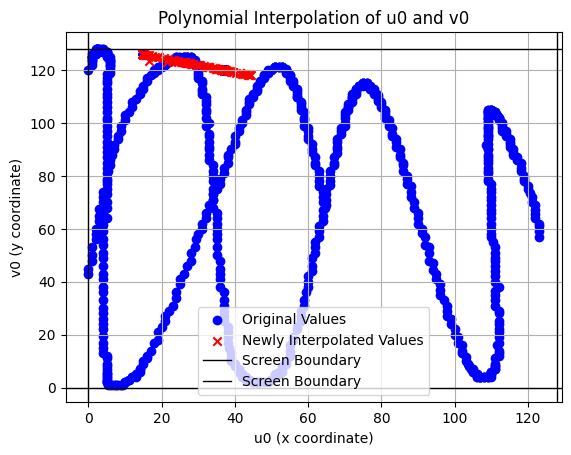

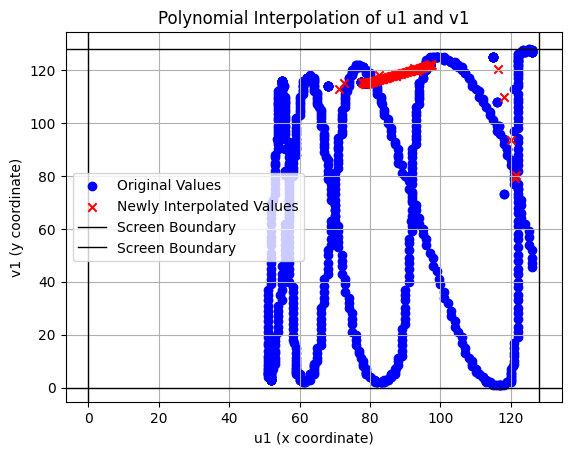

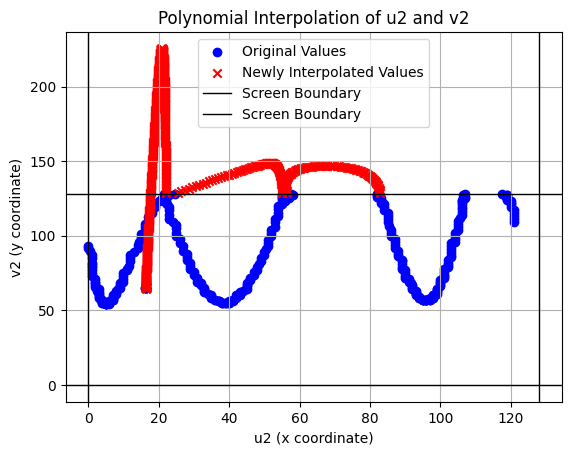

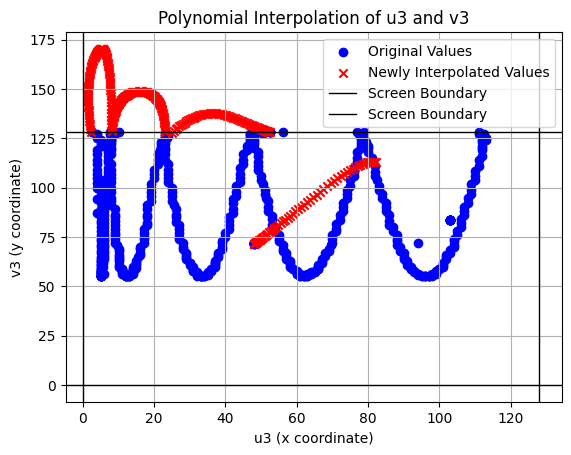

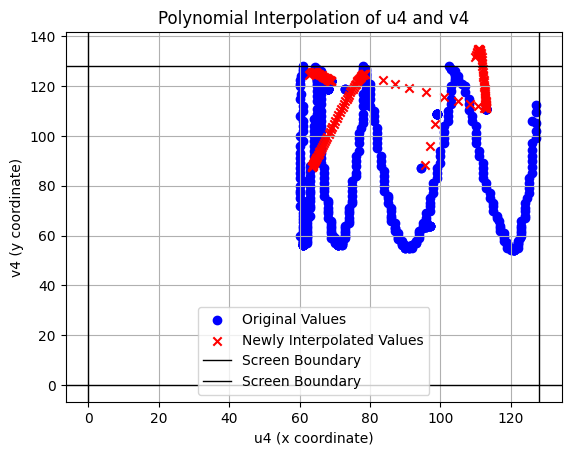

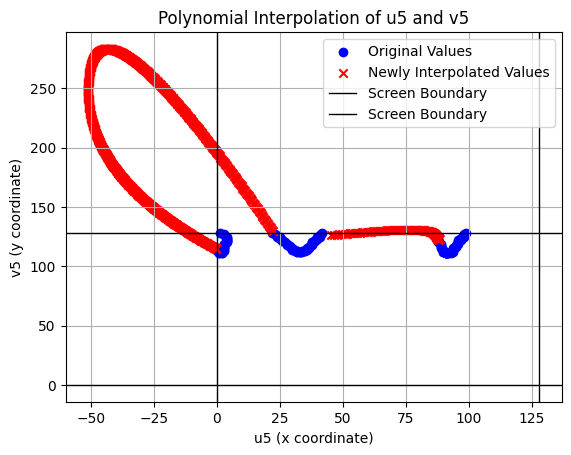

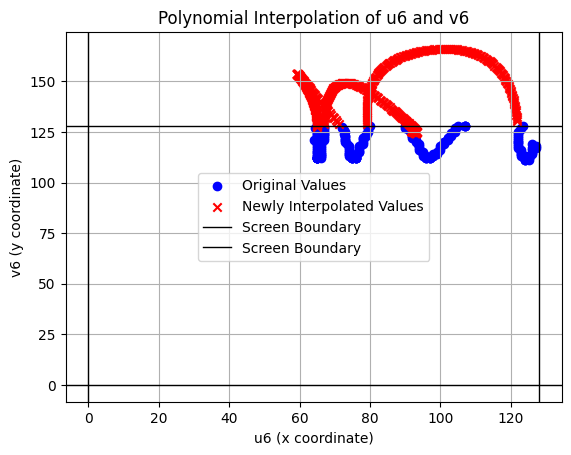

In [304]:

# Number of cameras
num_cameras = 7
result_df = red_ball_fill.copy()

# Loop through each pair of 'u' and 'v'
for i in range(num_cameras):
    col_u = f'u{i}'
    col_v = f'v{i}'

    # Extract the columns 'u' and 'v' for the current pair
    X_0 = red_ball_fill[[col_u, col_v]]

    # Create a copy to keep non-NaN rows
    X_0_copy = X_0.copy()

    X_0_nan = X_0_copy[X_0_copy.isna().any(axis=1)]

    # Drop NaN rows for z-score calculation
    X_0_non_nan = X_0.dropna()

    # Apply Isolation Forest to detect outliers
    model = IsolationForest(contamination=float(0.2), max_samples='auto')
    model.fit(X_0_non_nan)
    outliers_mask = model.predict(X_0_non_nan) == -1

    # Drop rows identified as outliers
    for index in X_0_copy.index:
        if index in X_0_non_nan.index[outliers_mask]:
            X_0_copy = X_0_copy.drop(index)

    # Interpolate missing values
    X_0_copy.interpolate(method='polynomial', order=2, inplace=True)

    # Fill NaN values in the original DataFrame with the interpolated values
    X_0_nan = X_0_nan.fillna(X_0_copy)

    # Apply KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    X_0_copy = X_0_copy.to_numpy()
    X_0_copy = imputer.fit_transform(X_0_copy)

    # Convert X_0_copy back to a DataFrame
    X_0_copy = pd.DataFrame(X_0_copy, columns=[col_u, col_v])

    # Find the indices of NaN rows in the original DataFrame red_ball_fill
    nan_indices = X_0_nan.index
    result_df.loc[nan_indices, [col_u, col_v]] = X_0_copy[[col_u, col_v]]
    # Replace the corresponding rows in red_ball_fill with the imputed values from X_0_copy
    red_ball_fill.loc[nan_indices, [col_u, col_v]] = X_0_copy[[col_u, col_v]]

    # Plot the results for the current pair
    plt.scatter(X_0[col_u], X_0[col_v], c='blue', marker='o', label='Original Values')
    plt.scatter(X_0_nan[col_u], X_0_nan[col_v], c='red', marker='x', label='Newly Interpolated Values')

    # Add lines to represent the screen boundaries
    plt.axvline(x=128, color='black', linewidth=1, label='Screen Boundary')
    plt.axhline(y=128, color='black', linewidth=1)
    plt.axvline(x=0, color='black', linewidth=1, label='Screen Boundary')
    plt.axhline(y=0, color='black', linewidth=1)

    plt.title(f'Polynomial Interpolation of {col_u} and {col_v}')
    plt.xlabel(f'{col_u} (x coordinate)')
    plt.ylabel(f'{col_v} (y coordinate)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [305]:
red_ball_fill.isna().sum()

u0      0
v0      0
u1     27
v1     27
u2     50
v2     50
u3    115
v3    115
u4    112
v4    112
u5     27
v5     27
u6     38
v6     38
dtype: int64

In [306]:
#result_df.to_csv('../interpolated-data/red_ball_coordinates_128px_024_interpolated.csv', index=False)

### Restructure the interpolation process
- Use Isolation Forest to detect all outliers so the interpolation works better
- Use Polynomial Interpolation to fill in the missing values
- Remove all the rows where the values are still NaN

In [307]:
red_ball_fill = pd.read_csv('../test-data/red_ball_coordinates_128px_2024-02-27_15h51m.csv', delimiter=',', decimal='.')
red_ball_fill.shape

(1228, 14)

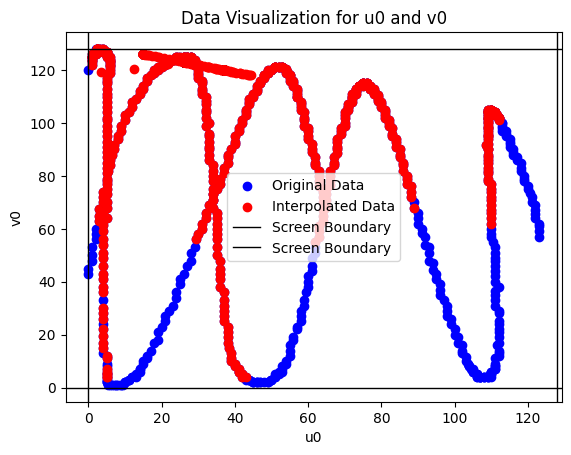

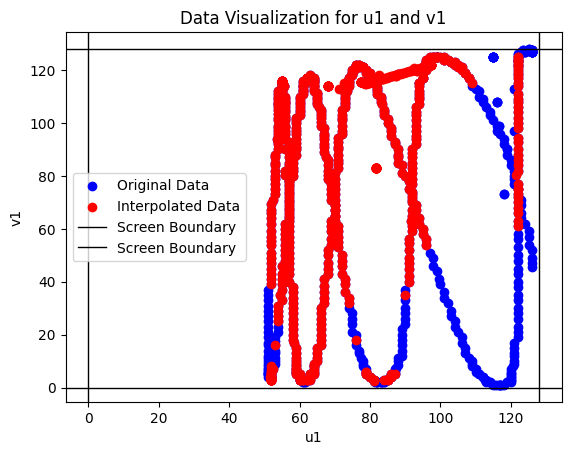

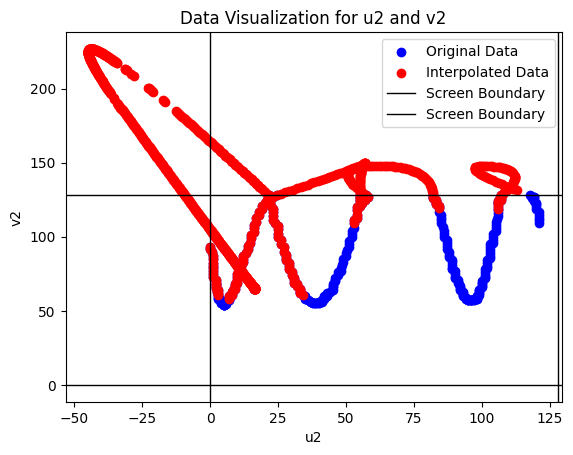

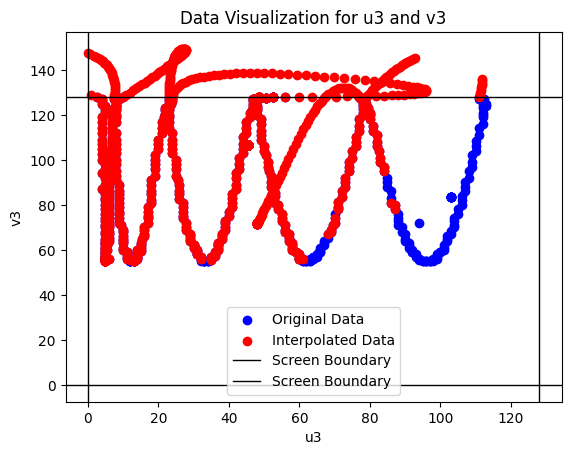

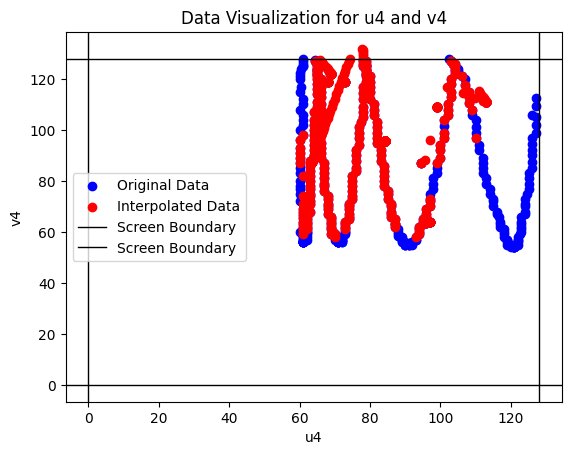

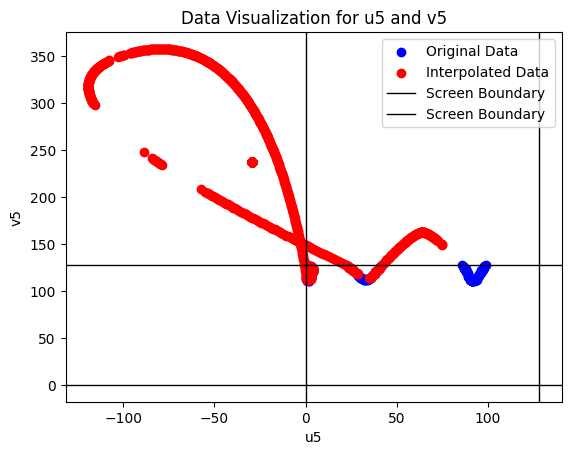

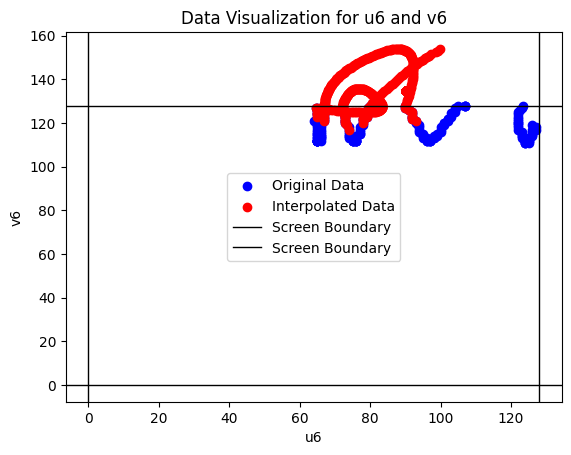

In [308]:

# Number of cameras
num_cameras = 7
result_df = red_ball_fill.copy()

# Loop through each pair of 'u' and 'v'
for i in range(num_cameras):
    col_u = f'u{i}'
    col_v = f'v{i}'

    # Extract the columns 'u' and 'v' for the current pair
    X_0 = red_ball_fill[[col_u, col_v]]
    X_0_original = X_0.copy()
    # do interpolation on the original data
    X_0_original = X_0_original.interpolate(method='polynomial', order=2)
    imputer_knn = KNNImputer(n_neighbors=5)
    X_0_original.to_numpy()
    X_0_original = imputer_knn.fit_transform(X_0_original)
    X_0_original = pd.DataFrame(X_0_original, columns=[col_u, col_v])
    # the outliers are removed from the data
    model_iso = IsolationForest(contamination=0.2)
    model_iso.fit(X_0_original)
    outliers_mask = model_iso.predict(X_0_original) == -1
    X_0_original = X_0_original[~outliers_mask]
    # Plot the original data in blue
    plt.scatter(X_0[col_u], X_0[col_v], color='blue', label='Original Data')
    
    # Plot the interpolated/red data in red
    plt.scatter(X_0_original[col_u], X_0_original[col_v], color='red', label='Interpolated Data')
    plt.axvline(x=128, color='black', linewidth=1, label='Screen Boundary')
    plt.axhline(y=128, color='black', linewidth=1)
    plt.axvline(x=0, color='black', linewidth=1, label='Screen Boundary')
    plt.axhline(y=0, color='black', linewidth=1)
    # Customize the plot
    plt.title(f'Data Visualization for {col_u} and {col_v}')
    plt.xlabel(col_u)
    plt.ylabel(col_v)
    plt.legend()
    
    # Show the plot
    plt.show()

#### Do Interpolation for X and Y coordinates separately

In [309]:
red_ball_fill = pd.read_csv('../test-data/red_ball_coordinates_128px_2024-02-27_15h51m.csv', delimiter=',', decimal='.')
red_ball_fill.shape

(1228, 14)

The number of NaN values in u0 before interpolation is 181
The number of NaN values in u0 after interpolation is 0
The number of NaN values in u0 after KNN imputation is 0


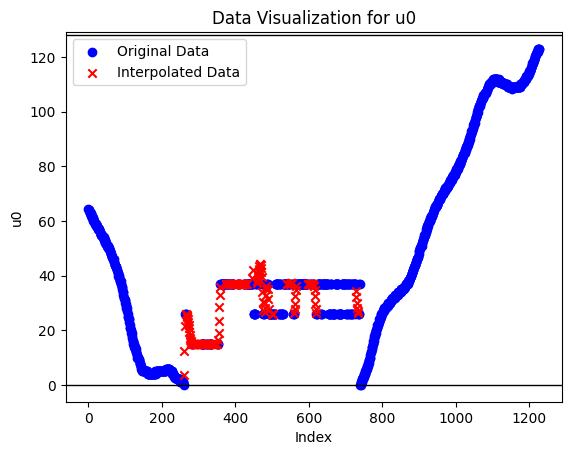

The number of NaN values in v0 before interpolation is 181
The number of NaN values in v0 after interpolation is 0
The number of NaN values in v0 after KNN imputation is 0


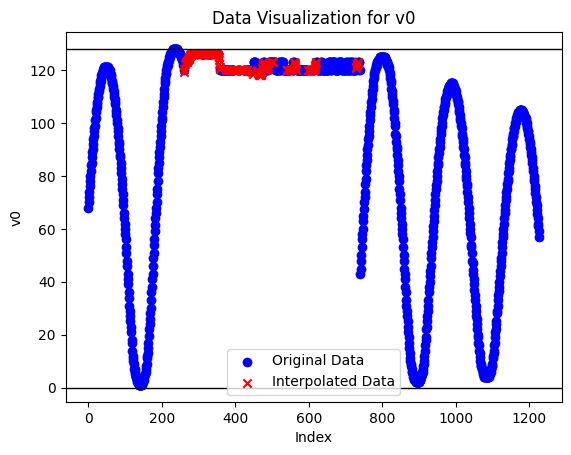

The number of NaN values in u1 before interpolation is 158
The number of NaN values in u1 after interpolation is 32
The number of NaN values in u1 after KNN imputation is 0


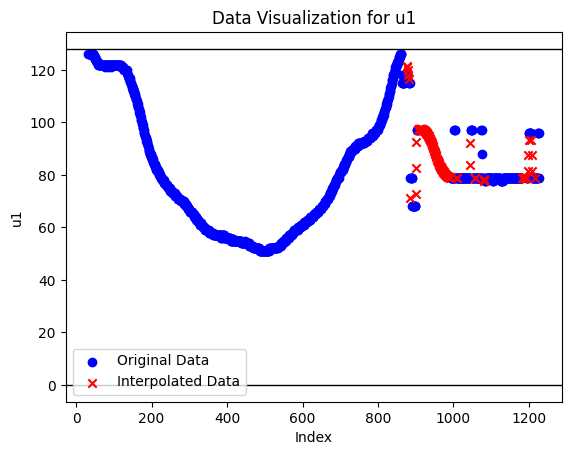

The number of NaN values in v1 before interpolation is 158
The number of NaN values in v1 after interpolation is 32
The number of NaN values in v1 after KNN imputation is 0


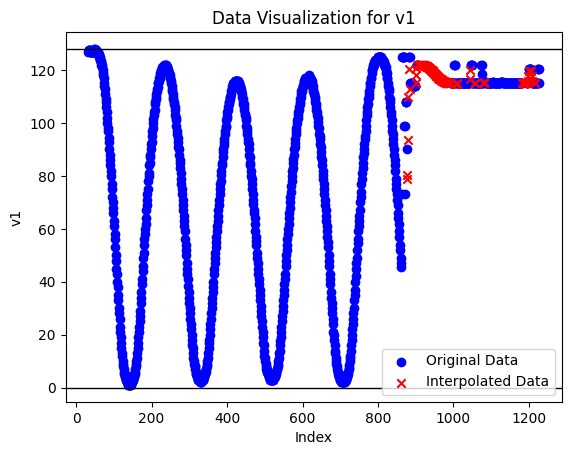

The number of NaN values in u2 before interpolation is 903
The number of NaN values in u2 after interpolation is 0
The number of NaN values in u2 after KNN imputation is 0


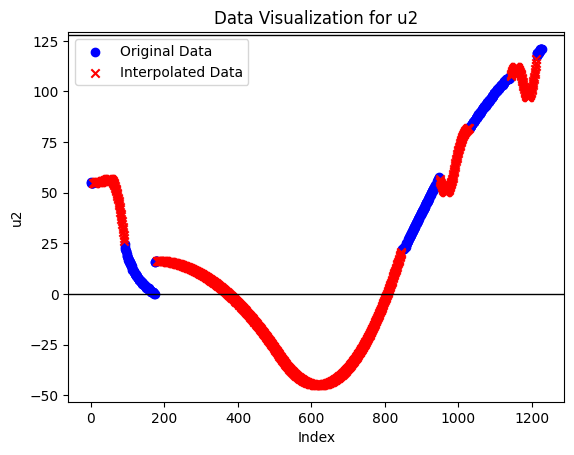

The number of NaN values in v2 before interpolation is 903
The number of NaN values in v2 after interpolation is 0
The number of NaN values in v2 after KNN imputation is 0


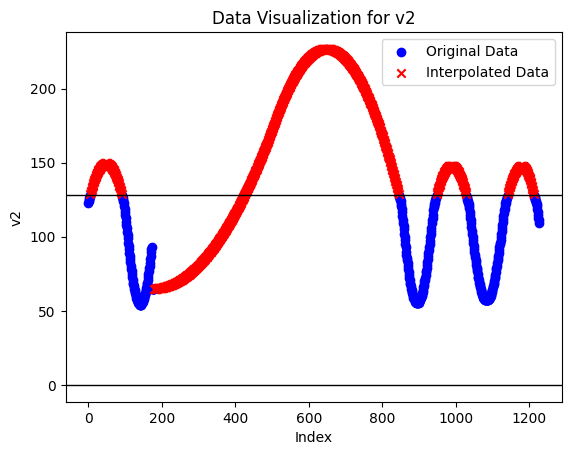

The number of NaN values in u3 before interpolation is 655
The number of NaN values in u3 after interpolation is 267
The number of NaN values in u3 after KNN imputation is 0


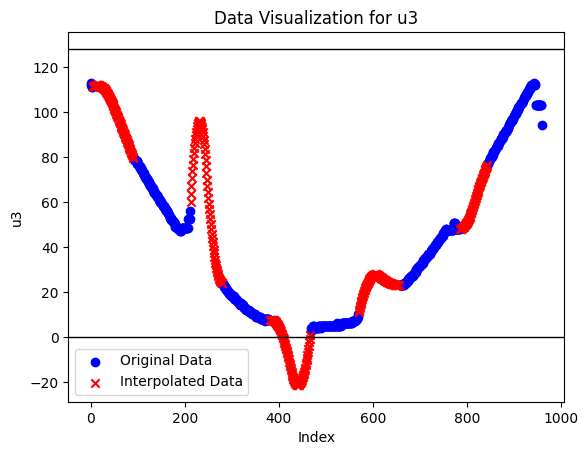

The number of NaN values in v3 before interpolation is 655
The number of NaN values in v3 after interpolation is 267
The number of NaN values in v3 after KNN imputation is 0


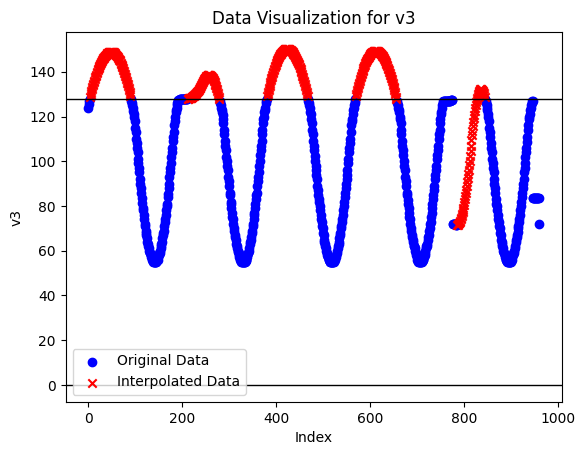

The number of NaN values in u4 before interpolation is 671
The number of NaN values in u4 after interpolation is 521
The number of NaN values in u4 after KNN imputation is 0


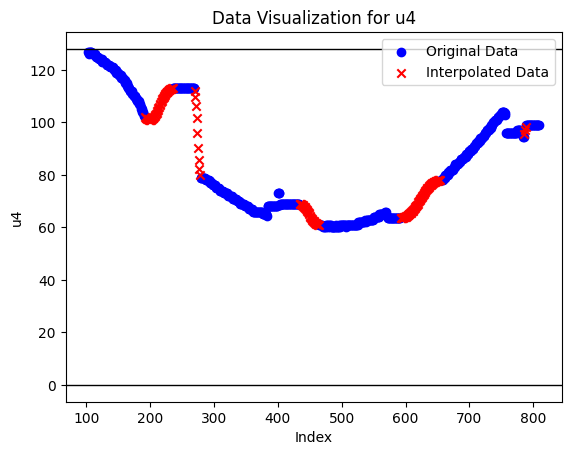

The number of NaN values in v4 before interpolation is 671
The number of NaN values in v4 after interpolation is 521
The number of NaN values in v4 after KNN imputation is 0


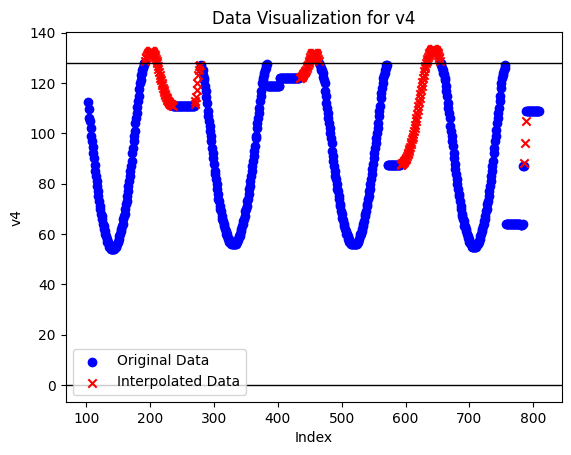

The number of NaN values in u5 before interpolation is 1095
The number of NaN values in u5 after interpolation is 236
The number of NaN values in u5 after KNN imputation is 0


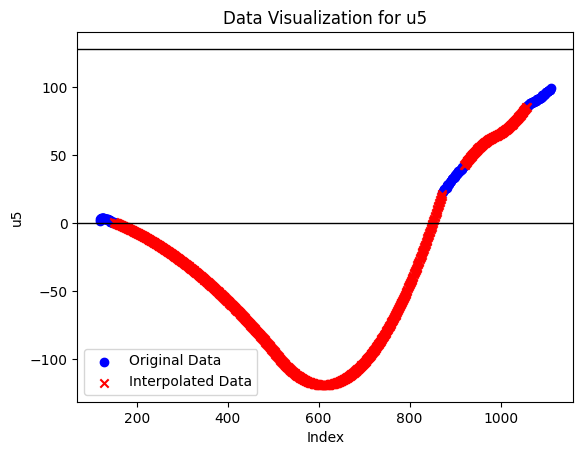

The number of NaN values in v5 before interpolation is 1095
The number of NaN values in v5 after interpolation is 236
The number of NaN values in v5 after KNN imputation is 0


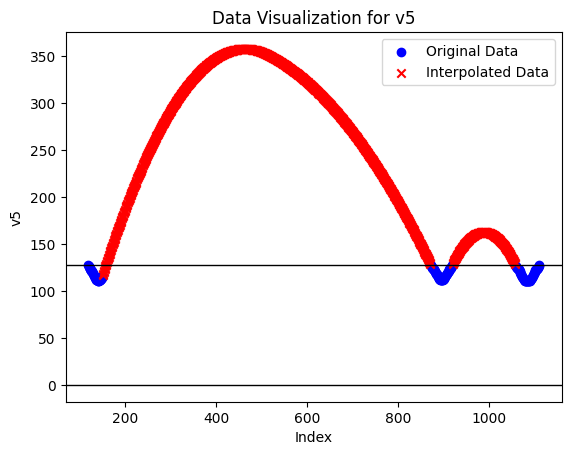

The number of NaN values in u6 before interpolation is 1040
The number of NaN values in u6 after interpolation is 621
The number of NaN values in u6 after KNN imputation is 0


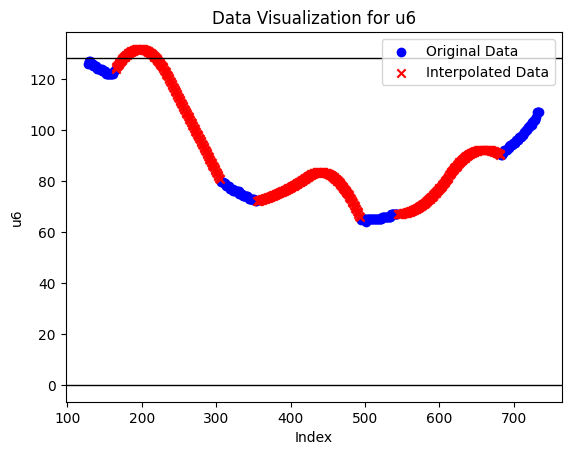

The number of NaN values in v6 before interpolation is 1040
The number of NaN values in v6 after interpolation is 621
The number of NaN values in v6 after KNN imputation is 0


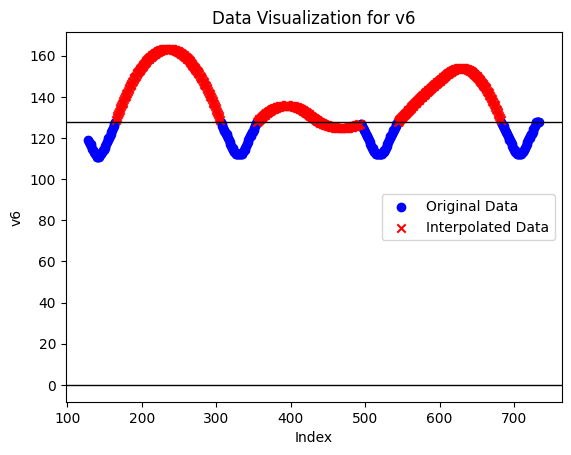

In [310]:

# Number of cameras
num_cameras = 7
result_df = red_ball_fill.copy()
new_data = pd.DataFrame()
# Loop through each pair of 'u' and 'v'
for col in red_ball_fill.columns:
    data = red_ball_fill[col].copy()
    original_indices = data.index
    original_values = data.values
    # get all the rows with NaN values
    data_nan = data[data.isna()]
    print(f'The number of NaN values in {col} before interpolation is {data.isna().sum()}')
    data = data.interpolate(method='polynomial', order=2)
    data_nan = data_nan.fillna(data)
    print(f'The number of NaN values in {col} after interpolation is {data.isna().sum()}')
    imputer_knn = KNNImputer(n_neighbors=2)
    data = data.values.reshape(-1, 1)
    data = imputer_knn.fit_transform(data)
    data = data.flatten()
    data = pd.DataFrame(data, columns=[col])
    # combine the original data with the interpolated data

    new_data = pd.concat([new_data, data], axis=1)
    print(f'The number of NaN values in {col} after KNN imputation is {data.isna().sum().values[0]}')
    plt.scatter(original_indices, original_values, color='blue', marker='o', label='Original Data')

    # Plot interpolated values in red crosses
    plt.scatter(data_nan.index, data_nan, color='red', marker='x', label='Interpolated Data')
    plt.axhline(y=128, color='black', linewidth=1)
    plt.axhline(y=0, color='black', linewidth=1)
    # Customize the plot
    plt.title(f'Data Visualization for {col}')
    plt.xlabel('Index')
    plt.ylabel(col)
    plt.legend()

    # Show the plot
    plt.show()

In [311]:
new_data

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6
0,64.5,68.0,81.583767,82.94092,55.5,123.0,113.000000,124.000000,84.286003,95.550908,-29.617042,237.188872,90.315662,134.650737
1,64.0,70.0,81.583767,82.94092,55.0,124.0,112.000000,125.500000,84.286003,95.550908,-29.617042,237.188872,90.315662,134.650737
2,64.0,72.0,81.583767,82.94092,55.0,125.0,111.000000,127.000000,84.286003,95.550908,-29.617042,237.188872,90.315662,134.650737
3,64.0,74.0,81.583767,82.94092,55.0,126.0,111.000000,128.000000,84.286003,95.550908,-29.617042,237.188872,90.315662,134.650737
4,63.0,76.0,81.583767,82.94092,55.0,127.0,111.157270,128.897843,84.286003,95.550908,-29.617042,237.188872,90.315662,134.650737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,122.0,64.0,79.000000,115.00000,121.0,117.0,45.465763,106.746940,84.286003,95.550908,-29.617042,237.188872,90.315662,134.650737
1224,123.0,62.0,96.000000,120.50000,121.0,115.0,45.465763,106.746940,84.286003,95.550908,-29.617042,237.188872,90.315662,134.650737
1225,123.0,61.0,96.000000,120.50000,121.0,113.0,45.465763,106.746940,84.286003,95.550908,-29.617042,237.188872,90.315662,134.650737
1226,123.0,57.0,79.000000,115.00000,121.0,109.0,45.465763,106.746940,84.286003,95.550908,-29.617042,237.188872,90.315662,134.650737


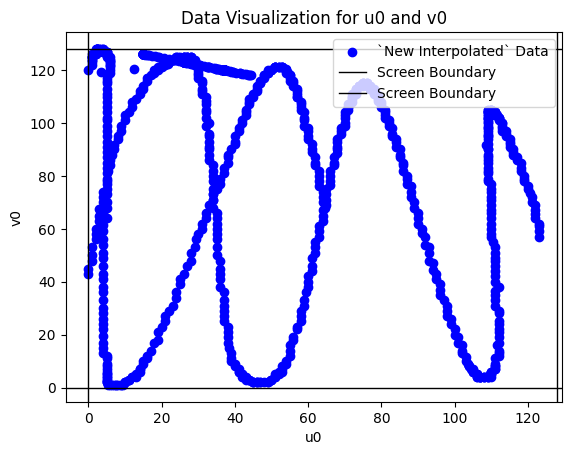

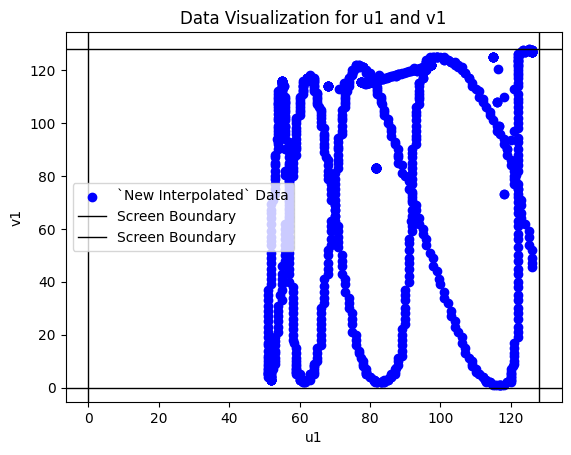

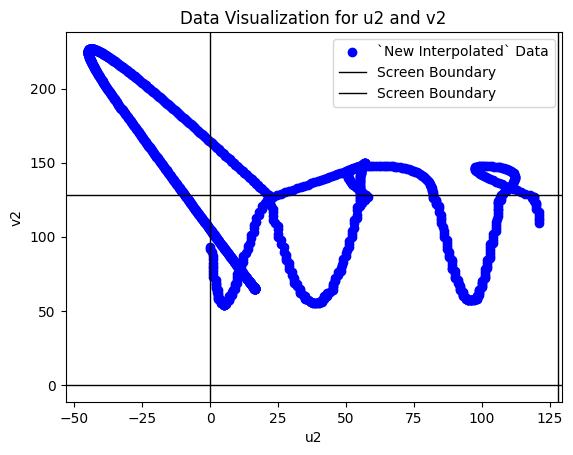

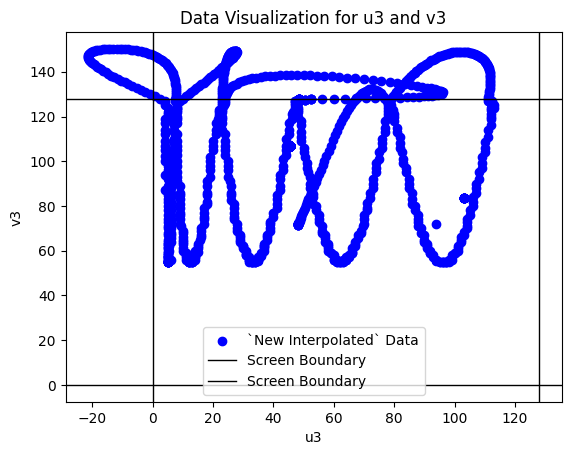

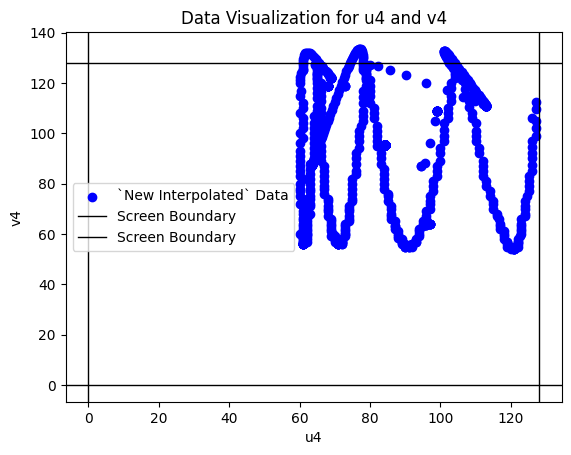

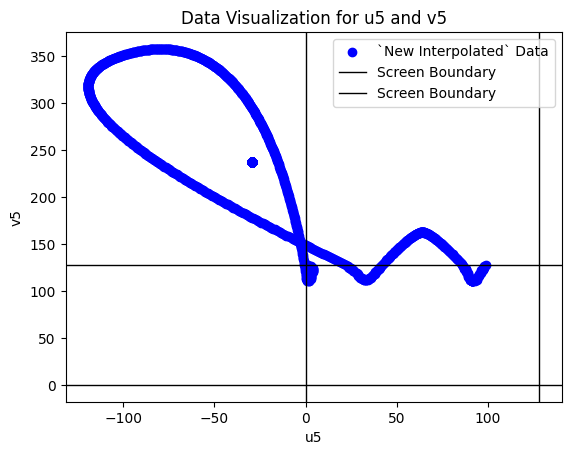

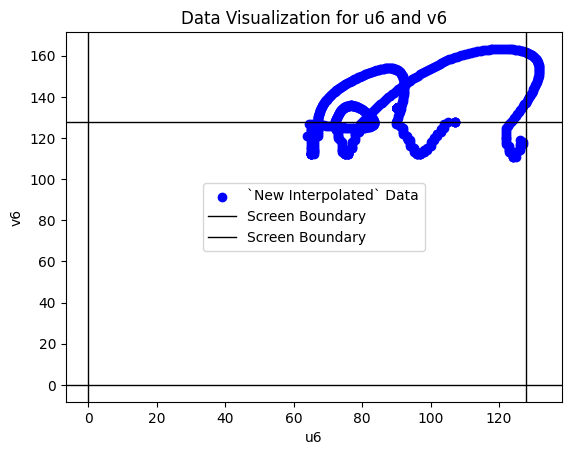

In [312]:
# plot new_data by camera
for i in range(num_cameras):
    col_u = f'u{i}'
    col_v = f'v{i}'
    plt.scatter(new_data[col_u], new_data[col_v], color='blue', marker='o', label='`New Interpolated` Data')
    plt.axvline(x=128, color='black', linewidth=1, label='Screen Boundary')
    plt.axhline(y=128, color='black', linewidth=1)
    plt.axvline(x=0, color='black', linewidth=1, label='Screen Boundary')
    plt.axhline(y=0, color='black', linewidth=1)
    plt.title(f'Data Visualization for {col_u} and {col_v}')
    plt.xlabel(col_u)
    plt.ylabel(col_v)
    plt.legend()
    plt.show()

In [313]:
new_data.to_csv('../interpolated-data/red_ball_coordinates_128px_2024-02-27_15h51m', index=False)